In [1]:
import glob # library to import multiples .csv files
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score

# Limpando os dados

In [2]:
#Obtendo e concatenando os dados de todos os dias em um database só
path = "Data/ufms"
dados_inversor = pd.concat(map(pd.read_csv, glob.glob(path + "/inversor_*.csv")))
dados_inversor.shape[0]
dados_inversor = dados_inversor.reset_index(drop = 'True') #Precisamos resetar o index para a contagem ficar correta e remover a coluna index
dados_inversor

,dia_mes_ano,hora_minuto,P_AC,I_AC,I_DC,V_AC,V_DC,IRR
0,20191004,52100,9,0.10,0.09,220.0,461.7,6
1,20191004,52200,12,0.10,0.10,220.1,440.0,6
2,20191004,52300,19,0.12,0.10,218.7,481.5,6
3,20191004,52400,27,0.15,0.12,218.8,466.9,7
4,20191004,52500,33,0.18,0.13,218.3,482.4,7
...,...,...,...,...,...,...,...,...
198236,20200318,205000,0,0.11,0.00,215.4,39.8,0
198237,20200318,205100,0,0.11,0.00,215.4,39.8,0
198238,20200318,205200,0,0.11,0.00,215.4,39.8,0
198239,20200318,205300,0,0.11,0.00,215.4,39.8,0


In [3]:
#Removendo valores nulos de P_AC
selecao = dados_inversor['P_AC'] != 0
print(dados_inversor.shape[0])
dados_inversor = dados_inversor[selecao]
print(dados_inversor.shape[0])
dados_inversor = dados_inversor.reset_index(drop = 'True') #Precisamos resetar o index para a contagem ficar correta e remover a coluna index

198241
122611


In [4]:
#Removendo valores nulos de IRR
selecao = dados_inversor['IRR'] != 0
print(dados_inversor.shape[0])
dados_inversor = dados_inversor[selecao]
print(dados_inversor.shape[0])
dados_inversor = dados_inversor.reset_index(drop = 'True') #Precisamos resetar o index para a contagem ficar correta e remover a coluna index

122611
122584


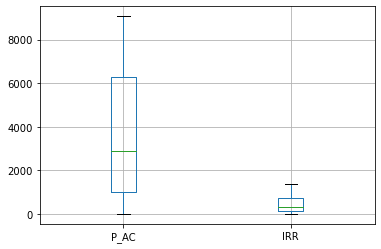

In [5]:
#Verificando a presença de outlayers
boxplot = dados_inversor.boxplot(column=['P_AC', 'IRR'])
#Podemos ver que os dados após a remoção dos números nulos e NaN's não contém outlayers na potência e nem na irradiancia

# Visualizando os dados de 1 em 1 minuto

## Ajustando a data para ficar no formato datetime da biblioteca pandas para possivel utilização de resample()

In [6]:
#Após pesquisar sobre a função resample do pandas, foi necessário criar uma medida de timestamp com os dados de data do sistema para assim conseguir utilizar a função
#primeiro criei uma váriavel "data" para armazenar o conunto de dia_mes_ano com hora_minuto

# Adicionando um zero no inicio do valor hora_minuto para facilitar a extração dos mesmos
dados_inversor['hora_minuto2'] = '0' + dados_inversor['hora_minuto'].astype(str)

#Criei uma váriavel "data_cru" para obter os dois valores numa mesma variavel
dados_inversor["data_cru"] = dados_inversor['dia_mes_ano'].astype(str) +"-"+ dados_inversor['hora_minuto2'].astype(str)

dados_inversor.drop('hora_minuto2',inplace = True, axis = 1)

dados_inversor["data_cru"]

0          20191004-052100
1          20191004-052200
2          20191004-052300
3          20191004-052400
4          20191004-052500
                ...       
122579    20200318-0174000
122580    20200318-0174100
122581    20200318-0174200
122582    20200318-0174300
122583    20200318-0174400
Name: data_cru, Length: 122584, dtype: object

In [7]:
# Agora precisamos incluir barras / e : nas medidas de tempo com isso conseguimos um valor "padrão" de medida de tempo
dados_inversor['data'] = (
    dados_inversor['data_cru'].str[:4] + '-' + #Ano
    dados_inversor['data_cru'].str[4:6]  + '-' + #Mês
    dados_inversor['data_cru'].str[6:8] + ' ' + #dia
    
    dados_inversor['data_cru'].str[-6:-4] + ':' + #Hora
    dados_inversor['data_cru'].str[-4:-2] + ':' + #Minuto
    dados_inversor['data_cru'].str[-2:] # Segundo
)
#Removendo data_cru
dados_inversor.drop('data_cru', inplace = True, axis=1)


In [8]:
#Convertendo data para datetime do pandas
dados_inversor['data'] = pd.to_datetime(dados_inversor['data'], errors = 'coerce')
dados_inversor['data']

0        2019-10-04 05:21:00
1        2019-10-04 05:22:00
2        2019-10-04 05:23:00
3        2019-10-04 05:24:00
4        2019-10-04 05:25:00
                 ...        
122579   2020-03-18 17:40:00
122580   2020-03-18 17:41:00
122581   2020-03-18 17:42:00
122582   2020-03-18 17:43:00
122583   2020-03-18 17:44:00
Name: data, Length: 122584, dtype: datetime64[ns]

In [9]:
#Removendo as colunas que agora estão contidas na data
dados_inversor.drop('hora_minuto', inplace = True, axis=1)
dados_inversor.drop('dia_mes_ano', inplace = True, axis=1)

#Colocando a data como index para poder ser utilizada a função resample futuramente
dados_inversor['data'] = dados_inversor['data'].dt.floor(freq='T')
dados_inversor.set_index('data', inplace = True)
dados_inversor.head(10)


,P_AC,I_AC,I_DC,V_AC,V_DC,IRR
data,,,,,,
2019-10-04 05:21:00,9,0.10,0.09,220.0,461.7,6
2019-10-04 05:22:00,12,0.10,0.10,220.1,440.0,6
2019-10-04 05:23:00,19,0.12,0.10,218.7,481.5,6
2019-10-04 05:24:00,27,0.15,0.12,218.8,466.9,7
2019-10-04 05:25:00,33,0.18,0.13,218.3,482.4,7
2019-10-04 05:26:00,39,0.20,0.14,217.5,494.2,7
2019-10-04 05:27:00,48,0.23,0.15,217.5,485.4,9
2019-10-04 05:28:00,54,0.27,0.17,217.5,491.6,9
2019-10-04 05:29:00,66,0.31,0.18,217.5,502.0,10


## Criando a medida PR para cada minuto

In [10]:
# PR = Energia Gerada / (Energia Ideal, IRR = 1000 e Temp = 25C) * (Insolação do periodo (média ou soma)) / 1000
# Recalcular ou refazer essa medida (o valor padrão está muito estranho)
dados_inversor['PR'] = dados_inversor['P_AC'] / (8250 * dados_inversor['IRR'] / 1000)


## Obtendo os valores de R² e fitline

In [11]:
#importando e definindo a função necessária para calcular r²
from scipy import stats
def rsquared(x, y):
    """ Return R^2 where x and y are array-like."""

    slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)
    return r_value**2

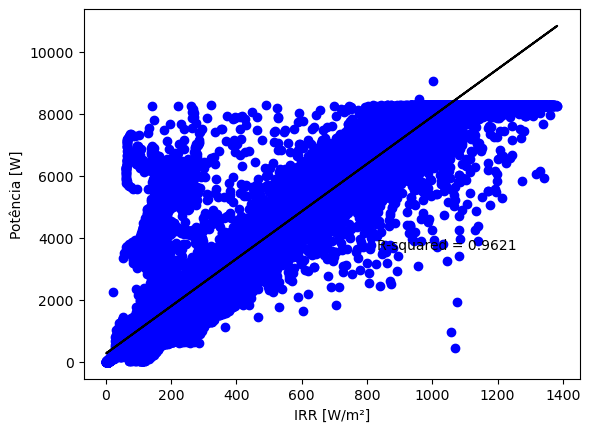

R-square =  0.9621464425026913


In [12]:
#Plotando um gráfico scatter de todos os dias com uma fit line e o R²
plt.scatter(dados_inversor['IRR'],dados_inversor['P_AC'], color = "blue")
plt.xlabel("IRR [W/m²]")
plt.ylabel("Potência AC [W]")

a, b = np.polyfit(dados_inversor['IRR'],dados_inversor['P_AC'], 1) #Encontrando a melhor fit line (R²) entre os dois valores
plt.plot(dados_inversor["IRR"], a*dados_inversor["IRR"]+b, color = "black",)
r2 = rsquared(dados_inversor['IRR'],dados_inversor['P_AC'])
plt.text(0.7*dados_inversor['IRR'].max(), 0.2*dados_inversor['P_AC'].max(), 'R-squared = %0.4f' % r2, color = "black")
plt.show()

print("R-square = ", r2)

## Retirando as medidas "defeituosas"

In [13]:
limite = 500
selecao_erros = (dados_inversor['P_AC'] > a*dados_inversor['IRR']+b + limite) | (dados_inversor['P_AC'] < a*dados_inversor['IRR']+b - limite)
dados_errados = dados_inversor[selecao_erros]
dados_certos = dados_inversor[~selecao_erros]

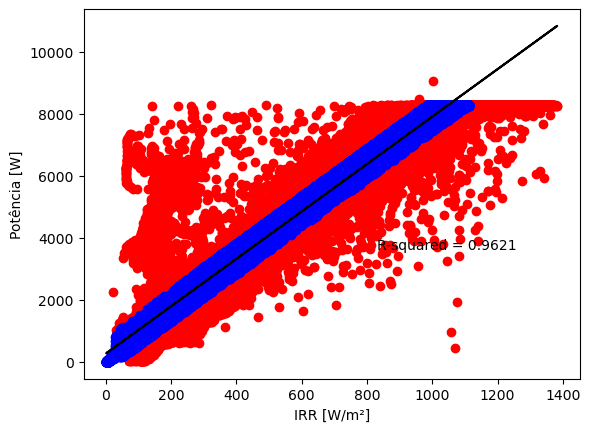

In [14]:
#plotando os valores dentro e fora da faixa definida
plt.scatter(dados_errados['IRR'],dados_errados['P_AC'], color = "red")
plt.scatter(dados_certos['IRR'],dados_certos['P_AC'], color = 'blue')
plt.xlabel("IRR [W/m²]")
plt.ylabel("Potência [W]")

a, b = np.polyfit(dados_inversor['IRR'],dados_inversor['P_AC'], 1) #Encontrando a melhor fit line entre os dois valores
plt.plot(dados_inversor["IRR"], a*dados_inversor["IRR"]+b, color = "black",)
r2 = rsquared(dados_inversor['IRR'],dados_inversor['P_AC'])
plt.text(0.6*dados_inversor['IRR'].max(), 0.4*dados_inversor['P_AC'].max(), 'R-squared = %0.4f' % r2, color = "black")
plt.show()

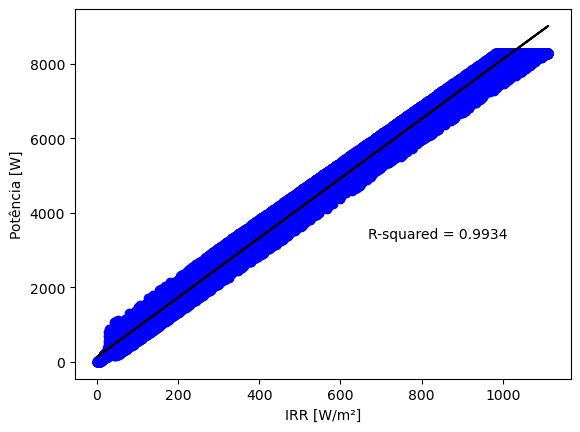

0.9934100830055027


In [15]:
#Imprimindo só os dados certos com o novo R² e a nova fit line
plt.scatter(dados_certos['IRR'],dados_certos['P_AC'], color = "blue")
plt.xlabel("IRR [W/m²]")
plt.ylabel("Potência [W]")

a, b = np.polyfit(dados_certos['IRR'],dados_certos['P_AC'], 1) #Encontrando a melhor fit line (R²) entre os dois valores
plt.plot(dados_certos["IRR"], a*dados_certos["IRR"]+b, color = "black",)
r2 = rsquared(dados_certos['IRR'],dados_certos['P_AC'])
plt.text(0.6*dados_certos['IRR'].max(), 0.4*dados_certos['P_AC'].max(), 'R-squared = %0.4f' % r2, color = "black")
plt.show()

print(r2)

## Incluindo no gráfico os valores nos quais a potência atinge o valor limite

In [16]:

selecao_PotOverLimit = ((dados_inversor['IRR'] > 1000) & (dados_inversor['P_AC'] > 8150) & (dados_inversor['P_AC'] < 8300))
dados_overlimit = dados_inversor[selecao_PotOverLimit]

frames = [dados_certos, dados_overlimit]
result = pd.concat(frames)

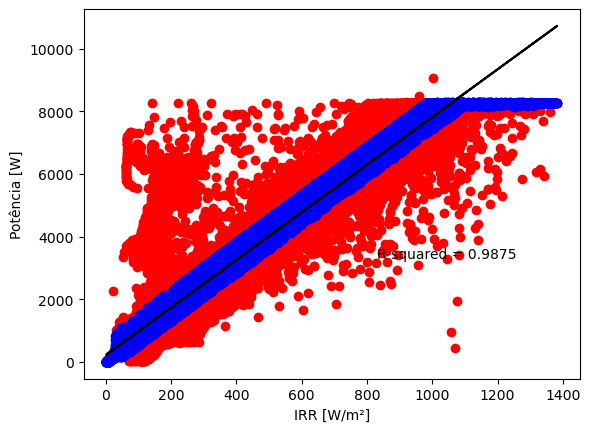

0.9875395316627305


In [17]:
#Plotando o resultado final com R² e fit line calculadas só dos valores certos
plt.scatter(dados_errados['IRR'],dados_errados['P_AC'], color = "red")
plt.scatter(result['IRR'],result['P_AC'], color = "blue")
plt.xlabel("IRR [W/m²]")
plt.ylabel("Potência [W]")

a, b = np.polyfit(result['IRR'],result['P_AC'], 1) #Encontrando a melhor fit line (R²) entre os dois valores
plt.plot(result["IRR"], a*result["IRR"]+b, color = "black",)

r2 = rsquared(result['IRR'],result['P_AC'])
plt.text(0.6*result['IRR'].max(), 0.4*result['P_AC'].max(), 'R-squared = %0.4f' % r2, color = "black")
plt.show()

print(r2)

## Salvando os dataframes como .csv obtidos até então

In [18]:
#Salvando os dados de todos os dias limpos em um arquivo .csv
path_bruno = "Data/Bruno/"
dados_inversor.to_csv(path_bruno + "dados_inversor_concatenados_e_limpos_1min.csv")
dados_certos.to_csv(path_bruno + "dados_certos_1min.csv") # não foram incluido os valores nos quais a potência atinge o máximo

# Utilizando Resample para 10min e vendo resultados

In [19]:
'''
Descoberto que a utilização do resample() inclui valores NaN para medidas que pulem mais de um periodo
Como a base de dados tem valores não muito estáveis acabou que incluiu alguns valores NaN na mesma,
sendo assim tive que retirar esses valores antes de conseguir calcular a fit line e o R² como podemos ver a seguir
'''

'\nDescoberto que a utilização do resample() inclui valores NaN para medidas que pulem mais de um periodo\nComo a base de dados tem valores não muito estáveis acabou que incluiu alguns valores NaN na mesma,\nsendo assim tive que retirar esses valores antes de conseguir calcular a fit line e o R² como podemos ver a seguir\n'

In [20]:
dados_inversor_10m = dados_inversor.resample("10Min").mean()



In [21]:
check_nan = dados_inversor['IRR'].isnull().values.any()
print(check_nan)

False


In [22]:
check_nan = dados_inversor_10m['IRR'].isnull().values.any()
print(check_nan)

True


In [23]:
dados_inversor_10m.dropna(inplace = True)
check_nan = dados_inversor_10m['IRR'].isnull().values.any()
print(check_nan)

False


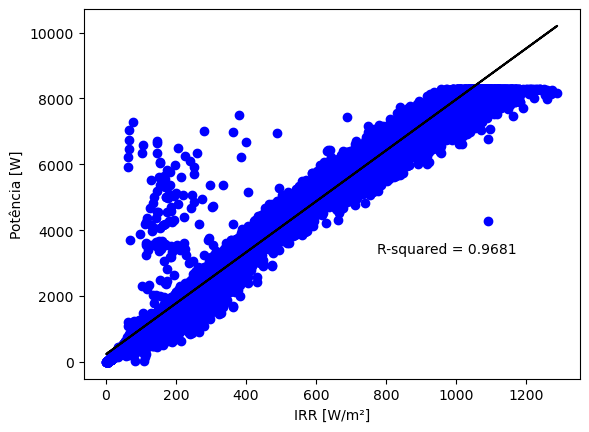

R-square =  0.9680646457185617


In [24]:
#Plotando um gráfico scatter de todos os dias com uma fit line e o R²
plt.scatter(dados_inversor_10m['IRR'],dados_inversor_10m['P_AC'], color = "blue")
plt.xlabel("IRR [W/m²]")
plt.ylabel("Potência [W]")

a, b = np.polyfit(dados_inversor_10m['IRR'],dados_inversor_10m['P_AC'], 1) #Encontrando a melhor fit line (R²) entre os dois valores
plt.plot(dados_inversor_10m["IRR"], a*dados_inversor_10m["IRR"]+b, color = "black",)
r2 = rsquared(dados_inversor_10m['IRR'],dados_inversor_10m['P_AC'])
plt.text(0.6*dados_inversor_10m['IRR'].max(), 0.4*dados_inversor_10m['P_AC'].max(), 'R-squared = %0.4f' % r2, color = "black")
plt.show()

print("R-square = ", r2)

In [25]:
limite = 500
selecao_erros = (dados_inversor_10m['P_AC'] > a*dados_inversor_10m['IRR']+b + limite) | (dados_inversor_10m['P_AC'] < a*dados_inversor_10m['IRR']+b - limite)
dados_errados_10m = dados_inversor_10m[selecao_erros]
dados_certos_10m = dados_inversor_10m[~selecao_erros]

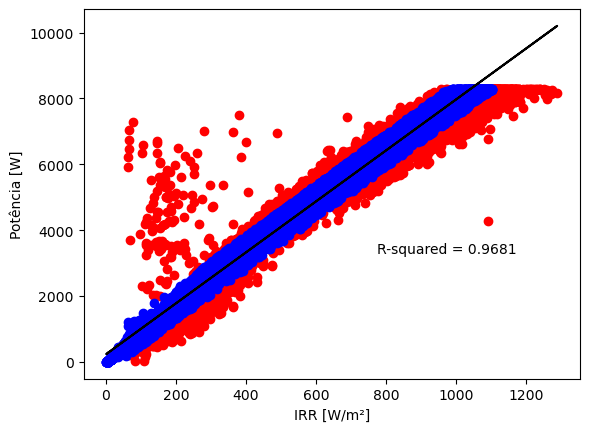

In [26]:
#plotando os valores dentro e fora da faixa definida
plt.scatter(dados_errados_10m['IRR'],dados_errados_10m['P_AC'], color = "red")
plt.scatter(dados_certos_10m['IRR'],dados_certos_10m['P_AC'], color = 'blue')
plt.xlabel("IRR [W/m²]")
plt.ylabel("Potência [W]")

a, b = np.polyfit(dados_inversor_10m['IRR'],dados_inversor_10m['P_AC'], 1) #Encontrando a melhor fit line entre os dois valores
plt.plot(dados_inversor_10m["IRR"], a*dados_inversor_10m["IRR"]+b, color = "black",)
r2 = rsquared(dados_inversor_10m['IRR'],dados_inversor_10m['P_AC'])
plt.text(0.6*dados_inversor_10m['IRR'].max(), 0.4*dados_inversor_10m['P_AC'].max(), 'R-squared = %0.4f' % r2, color = "black")
plt.show()

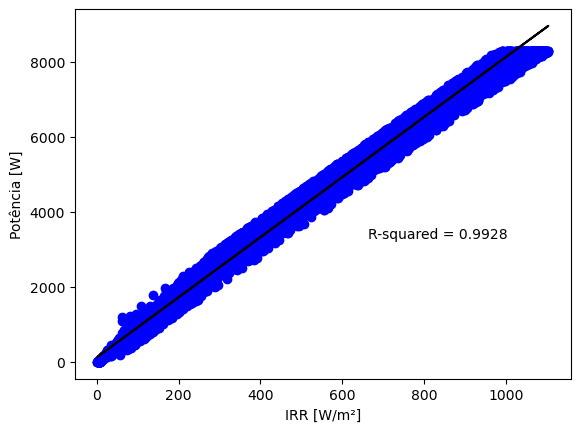

0.9928337032919895


In [27]:
#Imprimindo só os dados certos com o novo R² e a nova fit line
plt.scatter(dados_certos_10m['IRR'],dados_certos_10m['P_AC'], color = "blue")
plt.xlabel("IRR [W/m²]")
plt.ylabel("Potência [W]")

a, b = np.polyfit(dados_certos_10m['IRR'],dados_certos_10m['P_AC'], 1) #Encontrando a melhor fit line (R²) entre os dois valores
plt.plot(dados_certos_10m["IRR"], a*dados_certos_10m["IRR"]+b, color = "black",)
r2 = rsquared(dados_certos_10m['IRR'],dados_certos_10m['P_AC'])
plt.text(0.6*dados_certos_10m['IRR'].max(), 0.4*dados_certos_10m['P_AC'].max(), 'R-squared = %0.4f' % r2, color = "black")
plt.show()

print(r2)

# Utilizando Resample para fazer uma média por hora

In [28]:
dados_inversor_1h = dados_inversor.resample("60Min").mean()
dados_inversor_1h['P_AC'].isna().sum()

1759

In [29]:
print(dados_inversor_1h.shape[0])
check_nan = dados_inversor_1h['IRR'].isnull().values.any()
print(check_nan)

3997
True


In [30]:
dados_inversor_1h.dropna(inplace = True)
check_nan = dados_inversor_1h['IRR'].isnull().values.any()
print(check_nan)

False


In [31]:
print(dados_inversor_1h.shape[0])

2238


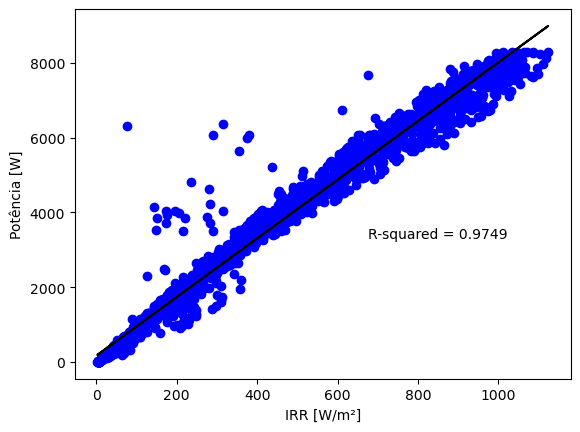

R-square =  0.9748953853626057


In [32]:
#Plotando um gráfico scatter de todos os dias com uma fit line e o R²
plt.scatter(dados_inversor_1h['IRR'],dados_inversor_1h['P_AC'], color = "blue")
plt.xlabel("IRR [W/m²]")
plt.ylabel("Potência [W]")

a, b = np.polyfit(dados_inversor_1h['IRR'],dados_inversor_1h['P_AC'], 1) #Encontrando a melhor fit line (R²) entre os dois valores
plt.plot(dados_inversor_1h["IRR"], a*dados_inversor_1h["IRR"]+b, color = "black",)
r2 = rsquared(dados_inversor_1h['IRR'],dados_inversor_1h['P_AC'])
plt.text(0.6*dados_inversor_1h['IRR'].max(), 0.4*dados_inversor_1h['P_AC'].max(), 'R-squared = %0.4f' % r2, color = "black")
plt.show()

print("R-square = ", r2)

In [33]:
limite = 500
selecao_erros = (dados_inversor_1h['P_AC'] > a*dados_inversor_1h['IRR']+b + limite) | (dados_inversor_1h['P_AC'] < a*dados_inversor_1h['IRR']+b - limite)
dados_errados_1h = dados_inversor_1h[selecao_erros]
dados_certos_1h = dados_inversor_1h[~selecao_erros]

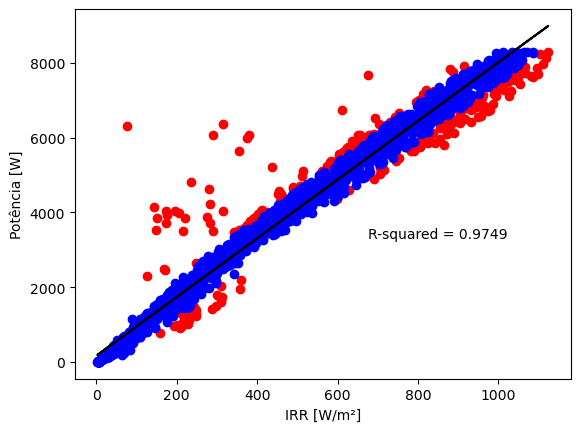

R-square =  0.9748953853626057


In [34]:
#plotando os valores dentro e fora da faixa definida
plt.scatter(dados_errados_1h['IRR'],dados_errados_1h['P_AC'], color = "red")
plt.scatter(dados_certos_1h['IRR'],dados_certos_1h['P_AC'], color = 'blue')
plt.xlabel("IRR [W/m²]")
plt.ylabel("Potência [W]")

a, b = np.polyfit(dados_inversor_1h['IRR'],dados_inversor_1h['P_AC'], 1) #Encontrando a melhor fit line entre os dois valores
plt.plot(dados_inversor_1h["IRR"], a*dados_inversor_1h["IRR"]+b, color = "black",)
r2 = rsquared(dados_inversor_1h['IRR'],dados_inversor_1h['P_AC'])
plt.text(0.6*dados_inversor_1h['IRR'].max(), 0.4*dados_inversor_1h['P_AC'].max(), 'R-squared = %0.4f' % r2, color = "black")
plt.show()
print("R-square = ", r2)

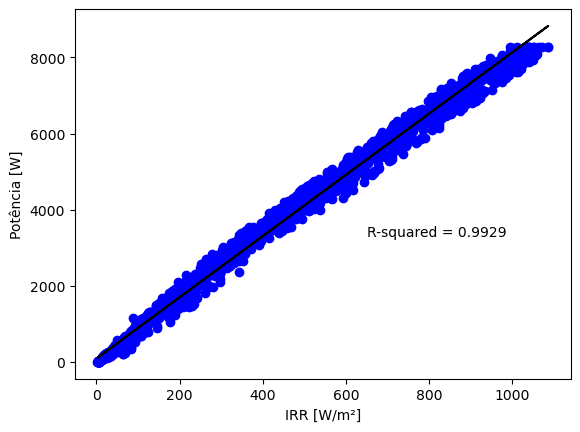

0.9928994880636841


In [35]:
#Imprimindo só os dados certos com o novo R² e a nova fit line
plt.scatter(dados_certos_1h['IRR'],dados_certos_1h['P_AC'], color = "blue")
plt.xlabel("IRR [W/m²]")
plt.ylabel("Potência [W]")

a, b = np.polyfit(dados_certos_1h['IRR'],dados_certos_1h['P_AC'], 1) #Encontrando a melhor fit line (R²) entre os dois valores
plt.plot(dados_certos_1h["IRR"], a*dados_certos_1h["IRR"]+b, color = "black",)
r2 = rsquared(dados_certos_1h['IRR'],dados_certos_1h['P_AC'])
plt.text(0.6*dados_certos_1h['IRR'].max(), 0.4*dados_certos_1h['P_AC'].max(), 'R-squared = %0.4f' % r2, color = "black")
plt.show()

print(r2)

# Utilizando Resample para Week para obter os PR's semanais

In [36]:
dados_inversor_1w = dados_inversor.resample("1W").mean()

In [37]:
check_nan = dados_inversor_1w['PR'].isnull().values.any()
print(check_nan)

False


In [38]:
dados_inversor_1w['PR']

data
2019-10-06    1.055409
2019-10-13    1.382692
2019-10-20    1.250186
2019-10-27    1.153086
2019-11-03    0.945989
2019-11-10    0.955752
2019-11-17    0.961236
2019-11-24    0.968240
2019-12-01    1.010620
2019-12-08    1.013086
2019-12-15    0.993597
2019-12-22    1.016964
2019-12-29    0.994527
2020-01-05    0.989524
2020-01-12    0.992375
2020-01-19    0.991740
2020-01-26    0.980889
2020-02-02    0.978332
2020-02-09    0.986892
2020-02-16    0.989582
2020-02-23    0.983717
2020-03-01    0.969724
2020-03-08    0.954525
2020-03-15    0.942667
2020-03-22    0.920329
Freq: W-SUN, Name: PR, dtype: float64